In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.metrics import accuracy_score

# Reconocimiento de dígitos con KNN



Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [23]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/gianluca/Documents/Metodos Numericos/tp2/bin/python (found version "3.8.2") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/gianluca/Documents/Metodos Numericos/github_g

In [2]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/gianluca/Documents/Metodos Numericos/github_grupal/metodos-num/tp2/notebooks
Python 3.8.2


## Explorando los datos

In [49]:
%load_ext autoreload
%autoreload 2

df_train = pd.read_csv("../data/train.csv")
df_train = df_train#[:5000]
df_train.info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


Es un csv, con columnas por cada pixel

In [58]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((42000, 784), (42000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 4


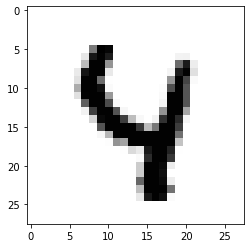

In [6]:
import matplotlib.pyplot as plt

num = 66

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [9]:
df_train["label"].value_counts(normalize=True)

2    0.124
0    0.107
7    0.105
4    0.102
9    0.097
6    0.097
1    0.096
8    0.093
3    0.090
5    0.089
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [13]:
X.shape

(5000, 784)

In [59]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


In [8]:
def pca(alpha, train,validacion):
    pca= metnum.PCA(alpha)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(validacion)
    return train_pca, val_pca


In [16]:
def train(k,alpha,X,y,X_val,y_val):
    X_pca, X_val_pca = pca(alpha,X,X_val)

    clf = metnum.KNNClassifier(k)
    clf.fit(X_pca, y)
    y_pred = clf.predict(X_val_pca)

    acc = accuracy_score(y_val, y_pred)
    print("Accuracy: {}".format(acc))


In [9]:
def numpy_to_csv(x,val,alpha,nset):
    df_x = pd.DataFrame(data=x)
    df_x.to_csv(f"transformaciones/{nset}_{alpha}_train.csv",index=False)
    df_val = pd.DataFrame(data=val)
    df_val.to_csv(f"transformaciones/{nset}_{alpha}_val.csv",index=False)

In [10]:
pot = metnum.power_iteration
pot(X_train)

(9.661754413708419e+296,
 array([0.00984409, 0.02513263, 0.00751778, ..., 0.01127815, 0.01205097,
        0.01405476]))

In [ ]:
eig = metnum.get_first_eigenvalues
eig_val ,eig_vec = eig(X_train,100)

In [16]:
alpha_max = 100
k_max = 50
salto_alpha = 2
salto_k = 5

alphas = [1] + [i*salto_alpha for i in range(1, int(alpha_max/salto_alpha) + 1)]
Ks = [1] + [i*salto_k for i in range(1,int(k_max/salto_k) + 1)]
#alphas , Ks

In [17]:
X_pca_max, X_val_pca_max = pca(alpha_max,X_train,X_val)
#numpy_to_csv(X_pca_max,X_val_pca_max,alpha_max,  )


In [18]:
from timeit import default_timer as timer
start = timer()

col_alphas = []
col_k = []
precisiones = []

for alpha in alphas :
    
    X_pca, X_val_pca = X_pca_max[0:, 0:alpha], X_val_pca_max[0:, 0:alpha]
    
    for k in Ks :
        
        clf = metnum.KNNClassifier(k)
        clf.fit(X_pca, y_train)
        y_pred = clf.predict(X_val_pca)
        acc = accuracy_score(y_val, y_pred)
        
        #para armar dsp el dataframe
        precisiones.append(acc)
        col_alphas.append(alpha)
        col_k.append(k)

        
        
end = timer()
print(end - start)

115.4206039769997


In [19]:
dat = pd.DataFrame({"Alpha":col_alphas,"K":col_k,"Precisión": precisiones})
dat = dat.pivot("Alpha","K","Precisión")
#dat.to_csv("10000_accuracy.csv",index = True,header = True)
dat

K,1,5,10,15,20,25,30,35,40,45,50
Alpha,,,,,,,,,,,
1,0.229,0.249,0.284,0.287,0.304,0.305,0.299,0.292,0.296,0.292,0.291
2,0.386,0.420,0.440,0.461,0.454,0.465,0.461,0.464,0.469,0.465,0.468
4,0.573,0.643,0.655,0.669,0.671,0.666,0.663,0.656,0.650,0.655,0.653
6,0.756,0.810,0.800,0.811,0.806,0.796,0.798,0.795,0.792,0.788,0.790
8,0.820,0.841,0.844,0.850,0.851,0.849,0.847,0.853,0.848,0.846,0.844
10,0.883,0.898,0.886,0.880,0.876,0.871,0.871,0.866,0.867,0.865,0.862
12,0.910,0.913,0.915,0.917,0.905,0.904,0.894,0.889,0.886,0.887,0.881
14,0.923,0.927,0.924,0.922,0.913,0.905,0.899,0.901,0.896,0.896,0.889
16,0.928,0.935,0.928,0.923,0.921,0.917,0.914,0.909,0.906,0.908,0.899


In [31]:
indmax = precisiones.index(max(precisiones))

best_alpha = col_alphas[indmax]
best_k = col_k[indmax]
print(f" Mejor (alpha, k): ({col_alphas[indmax]}, {col_k[indmax]})")
print(f"Precicison : {precisiones[indmax]}" )

 Mejor (alpha, k): (26, 5)
Precicison : 0.948


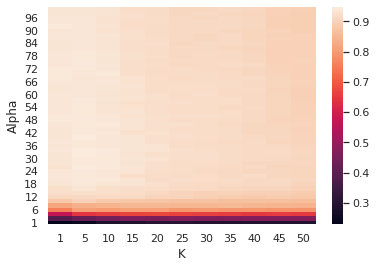

In [25]:
import seaborn as sns; sns.set()

hmap = sns.heatmap(dat)#,annot = True)#,cmap = "YlGnBu") # colores de mapa claros
hmap.invert_yaxis()
#plt.title("8000 de train y 2000 de validacion (primeros)")
#plt.savefig("10000_hmap.png")

# Recall y Precision sobre la mejor pareja

In [95]:
#Mejor pareja dataset completo 
dfcomp = pd.read_csv("42000_accuracy.csv")
display(dfcomp)
dfcomp.max().to_list()
#alpha = 45 o 50 y k = 5
best_k = 5
best_alpha = 45
#hmap = sns.heatmap(dfcomp,index = None)#,annot = True)#,cmap = "YlGnBu") # colores de mapa claros
#hmap.invert_yaxis()

,Alpha,1,5,10,15,20,25,30,35,40
0,1,0.256905,0.272976,0.282857,0.289762,0.292262,0.293333,0.295952,0.297024,0.296667
1,5,0.686786,0.736548,0.748333,0.752500,0.756905,0.755238,0.756905,0.755714,0.753452
2,10,0.907857,0.922619,0.923690,0.921667,0.918333,0.916548,0.915238,0.914167,0.913214
3,15,0.949405,0.956429,0.951310,0.951310,0.948571,0.947024,0.945000,0.944405,0.941548
4,20,0.962738,0.967262,0.963810,0.962619,0.960119,0.958571,0.956786,0.954405,0.952619
5,25,0.965119,0.971429,0.967619,0.966905,0.964881,0.961905,0.960714,0.957619,0.956548
6,30,0.968214,0.973571,0.970357,0.969762,0.965952,0.964405,0.960714,0.959762,0.958571
7,35,0.970476,0.973452,0.971190,0.968571,0.967024,0.964643,0.962500,0.959762,0.959286
8,40,0.971310,0.973929,0.970357,0.968095,0.965476,0.963690,0.961786,0.960595,0.957619
9,45,0.971071,0.974167,0.971786,0.968690,0.964881,0.963690,0.960000,0.959167,0.957024


In [69]:
X_pca, X_val_pca = pca(best_alpha,X_train,X_val)


In [70]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score, precision_score

clf = metnum.KNNClassifier(best_k)
clf.fit(X_pca, y_train)
y_pred = clf.predict(X_val_pca)

acc = accuracy_score(y_val, y_pred)
recall = recall_score(y_val, y_pred,average = None)
precision = precision_score(y_val, y_pred, average=None)
#recall,precision,acc

In [71]:
acc

0.9741666666666666

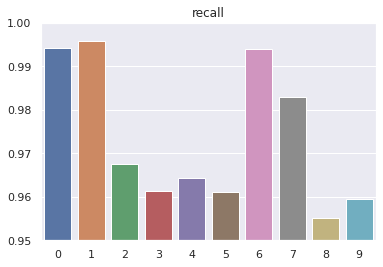

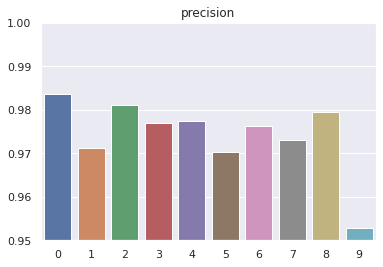

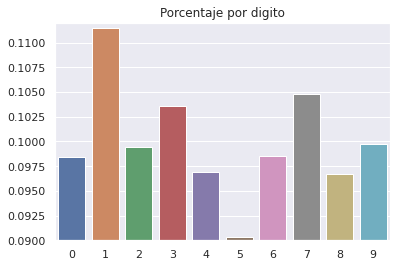

In [75]:
import matplotlib.pyplot as plt
ejex = [i for i in range(10)]
sns.barplot(x = ejex , y = recall)
plt.ylim(0.95, 1)
plt.title("recall")
plt.show()
sns.barplot(x = ejex , y = precision)
plt.ylim(0.95, 1)
plt.title("precision")
plt.show()
yy = df_train["label"].value_counts(normalize=True).sort_index().to_list()
sns.barplot(x = ejex , y = yy)
plt.ylim(0.09, 0.112)
plt.title("Porcentaje por digito")
plt.show()

# Cross Validation

In [90]:
dfpp = pd.read_csv("transformaciones/5000_2_train.csv")
dfpp.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49'],
      dtype='object')

In [81]:
from sklearn.model_selection import KFold
def work(X, y, clf, k):

    accuracy = []

    kf = KFold(n_splits=k)
    i = 1
    for train_index, test_index in kf.split(X):
        print(f"{os.getpid()} == kfold iteración {i}/{k}")

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy.append(accuracy_score(y_test, y_pred))
        i += 1

    return np.mean(accuracy)

[   0    1    2 ... 8397 8398 8399]


[ 8400  8401  8402 ... 16797 16798 16799]


[16800 16801 16802 ... 25197 25198 25199]


[25200 25201 25202 ... 33597 33598 33599]




# # Pruebas 2d y 3d

In [56]:
X_3d, X_val3d = pca(3,X_train,X_val)

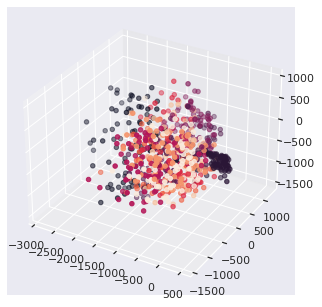

In [50]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = X_3d[:,0]
sequence_containing_y_vals = X_3d[:,1]
sequence_containing_z_vals = X_3d[:,2]

#random.shuffle(sequence_containing_x_vals)
#random.shuffle(sequence_containing_y_vals)
#random.shuffle(sequence_containing_z_vals)

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals,c = y_train)
pyplot.show()

In [55]:
X_2d, X_val2d = pca(2,X_train,X_val)

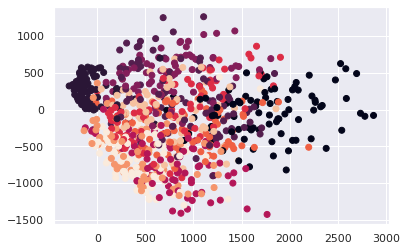

In [55]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random


fig = pyplot.figure()

sequence_containing_x_vals = X_2d[:,0]
sequence_containing_y_vals = X_2d[:,1]

#random.shuffle(sequence_containing_x_vals)
#random.shuffle(sequence_containing_y_vals)
#random.shuffle(sequence_containing_z_vals)

plt.scatter(sequence_containing_x_vals, sequence_containing_y_vals, c = y_train)
pyplot.show()